<h2 style="color: darkred;">Neuro Symbolic Robotics Planner</h2>


<h2 style="color: darkblue;">Importing libraries</h2>


In [19]:
from datasets import load_dataset
import ollama
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random


<h2 style="color: #ff7f0e;">Loading Dataset</h2>


In [18]:
from datasets import load_dataset
dataset = load_dataset("tau/commonsense_qa")
data = dataset["train"]
print(data[0])


README.md: 0.00B [00:00, ?B/s]

C:\Users\navya\AppData\Roaming\Python\Python313\site-packages\huggingface_hub\file_download.py:121: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\navya\.cache\huggingface\hub\datasets--tau--commonsense_qa. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


data/train-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/160k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/151k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9741 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1221 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1140 [00:00<?, ? examples/s]

{'id': '075e483d21c29a511267ef62bedc0461', 'question': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?', 'question_concept': 'punishing', 'choices': {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']}, 'answerKey': 'A'}


<h2 style="color: #2ca02c;">Counting Questions</h2>


In [21]:
dataset = load_dataset("tau/commonsense_qa")
data = dataset["train"]
print("Total questions:", len(data))


Total questions: 9741


<h2 style="color: brown;">Subsetting For Two Models </h2>


In [47]:
MODEL = "qwen2:0.5b"      
data100 = data.shuffle(seed=42).select(range(100))
len(data100)

100

In [48]:
MODEL = "mistral"
data20  = data.shuffle(seed=123).select(range(20))
len(data20)

20

<h2 style="color: seagreen;">Prompting Techniques</h2>


In [35]:
def zero_shot_prompt(q, choices):
    return f"Q: {q}\nChoices: {choices}\nAnswer with A, B, C, D, or E only:"
    

def few_shot_prompt(q, choices):
    return (
        "Q: Where do you keep milk?\nChoices: A: garage B: refrigerator C: shower D: car E: balcony\nA: B\n\n"
        "Q: What do you use to cut paper?\nChoices: A: pillow B: scissors C: shoes D: soap E: phone\nA: B\n\n"
        f"Q: {q}\nChoices: {choices}\nA:"
    )


def cot_prompt(q, choices):
    return (
        f"Think step by step but only give the final answer letter.\n"
        f"Q: {q}\nChoices: {choices}\nAnswer:"
    )


<h2 style="color: maroon;">Evaluating for Two Models</h2>


In [36]:
def ask(prompt):
    reply = ollama.chat(
        model=MODEL,
        messages=[{"role":"user","content":prompt}],
        options={
            "num_predict": 8,     # FAST
            "temperature": 0.0    # deterministic
        }
    )
    return reply["message"]["content"]


In [37]:
def ask(prompt):
    reply = ollama.chat(
        model=MODEL,
        messages=[{"role":"user","content":prompt}],
        options={
            "num_predict": 12,   # a bit more room for Mistral
            "temperature": 0.0
        }
    )
    return reply["message"]["content"]


<h2 style="color: peachpuff;">Cleaning Model Predictions </h2>


In [25]:
def clean(pred):
    pred = pred.upper().strip()
    for letter in ["A","B","C","D","E"]:
        if letter in pred:
            return letter
    return None


<h2 style="color: darkgoldenrod;">Model Evaluation Loops</h2>


In [26]:
results = {"zero": [], "few": [], "cot": []}

for item in tqdm(data100):
    q = item["question"]
    ch = " ".join(item["choices"])
    gt = item["answerKey"]   
    # zero-shot
    z = clean(ask(zero_shot_prompt(q, ch)))
    results["zero"].append((gt, z))

    # few-shot
    f = clean(ask(few_shot_prompt(q, ch)))
    results["few"].append((gt, f))

    # chain-of-thought
    c = clean(ask(cot_prompt(q, ch)))
    results["cot"].append((gt, c))


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [15:52<00:00,  9.52s/it]


In [39]:
results_m = {"zero": [], "few": [], "cot": []}

for item in tqdm(data20):
    q  = item["question"]

    # FIXING CHOICES FORMAT
    labels = item["choices"]["label"]
    texts  = item["choices"]["text"]
    choices = [f"{l}: {t}" for l, t in zip(labels, texts)]
    ch = " ".join(choices)

    gt = item["answerKey"]  
    # Zero-shot
    z = clean(ask(zero_shot_prompt(q, ch)))
    results_m["zero"].append((gt, z))

    # Few-shot
    f = clean(ask(few_shot_prompt(q, ch)))
    results_m["few"].append((gt, f))

    # Chain-of-thought
    c = clean(ask(cot_prompt(q, ch)))
    results_m["cot"].append((gt, c))


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:25<00:00,  4.27s/it]


<h2 style="color: darkslategray;">Computing Accuracy</h2>


In [ ]:
def acc(lst):
    correct = sum(1 for gt,p in lst if gt == p)
    return round(correct / len(lst) * 100, 2)


<h2 style="color: darkolivegreen;">Calculating and Printing Models Accuracy</h2>


In [41]:
acc_zero = acc(results["zero"])
acc_few  = acc(results["few"])
acc_cot  = acc(results["cot"])
acc_zero, acc_few, acc_cot


(17.0, 17.0, 14.0)

In [45]:

print(f"Zero-shot accuracy: {acc_zero:.1f} %")
print(f"Few-shot accuracy: {acc_few:.1f} %")
print(f"Chain-of-thought accuracy: {acc_cot:.1f} %")


Zero-shot accuracy: 17.0 %
Few-shot accuracy: 17.0 %
Chain-of-thought accuracy: 14.0 %


In [42]:
acc_zero_m = acc(results_m["zero"])
acc_few_m  = acc(results_m["few"])
acc_cot_m  = acc(results_m["cot"])

acc_zero_m, acc_few_m, acc_cot_m


(35.0, 25.0, 25.0)

In [46]:
print(f"Mistral Zero-shot accuracy: {acc_zero_m:.1f} %")
print(f"Mistral Few-shot accuracy: {acc_few_m:.1f} %")
print(f"Mistral Chain-of-thought accuracy: {acc_cot_m:.1f} %")


Mistral Zero-shot accuracy: 35.0 %
Mistral Few-shot accuracy: 25.0 %
Mistral Chain-of-thought accuracy: 25.0 %


<h2 style="color: navy;">Plotting Models Accuracy</h2>


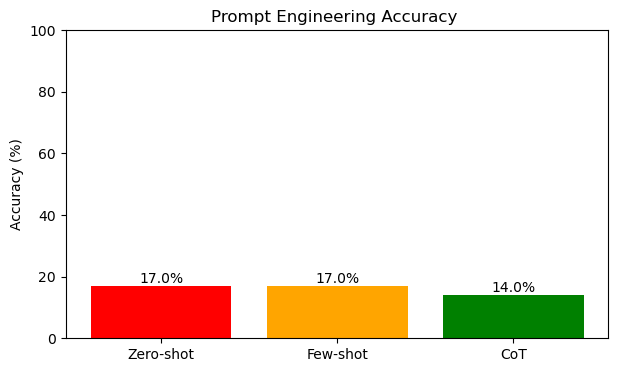

In [62]:
labels = ["Zero-shot", "Few-shot", "CoT"]
values = [acc_zero, acc_few, acc_cot]

plt.figure(figsize=(7,4))
bars = plt.bar(labels, values, color=["red","orange","green"])

plt.ylim(0,100)
plt.ylabel("Accuracy (%)")
plt.title("Prompt Engineering Accuracy ")

for bar, val in zip(bars, values):
    plt.text(bar.get_x()+bar.get_width()/2, val+1, f"{val}%", ha="center")

plt.show()


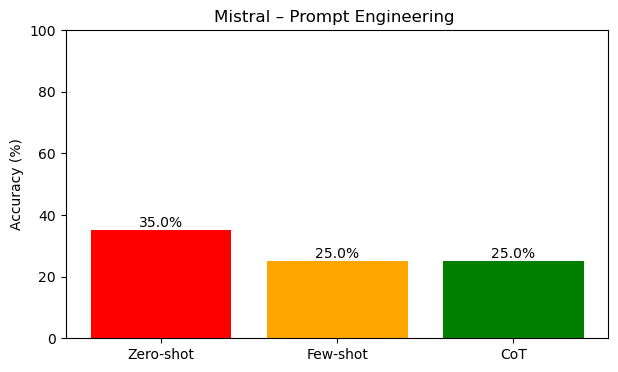

In [63]:
labels = ["Zero-shot", "Few-shot", "CoT"]
values_m = [acc_zero_m, acc_few_m, acc_cot_m]

plt.figure(figsize=(7,4))
bars = plt.bar(labels, values_m, color=["red","orange","green"])

plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("Mistral – Prompt Engineering ")

for bar, val in zip(bars, values_m):
    plt.text(bar.get_x() + bar.get_width()/2, val + 1, f"{val}%", ha="center")

plt.show()
